# Современные методы машинного обучения. Семинар 8. Автоэнкодеры

## 1. Подход 

Автоэнкодеры - unsupervised (не требующие разметки для обучения) модели, которые находят применение как базовые строительные блоки в огромном кол-ве сложных моделей.

Идея автоэнкодера крайне проста. Он состоит из двух нейронных сетей, называемых _энкодером_ и _декодером_, которые работают в тандеме. Задача энкодера - сжать исходный объект до вектора малой размерности, называемого _латентным кодом_. Задача декодера - восстановить из этого латентного кода исходный объект. 

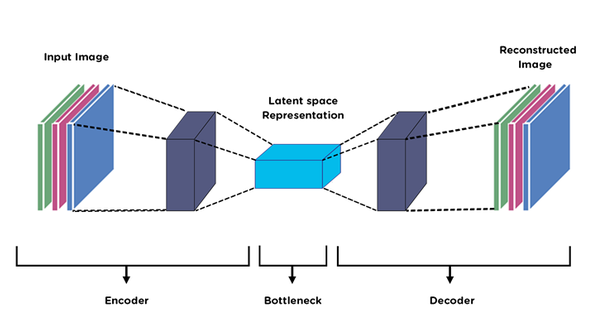

Источник картинки: [medium](https://medium.com/@birla.deepak26/autoencoders-76bb49ae6a8f)


Обучение происходит путем уменьшения ошибки между исходным объектом и восстановленным:

$$ Loss = \sum MSE(x_i, dec(enc(x_i)) $$

## 2. Пишем простой автоэнкодер для MNIST

Давайте реализуем и поиграемся с простым автоэнкодером, который берет изображения из датасета **MNIST** и кодирует их в латентный код длины **k**. В этом задании надо реализовать:

* Encoder
    * Четырехслойная полносвязная сеть с каналами (784-128-64-32-k)
* Decoder
    * Симметричная полносвязная сеть с каналами (k-32-64-128-784)
* Loss функцию для обучения
    * L2 между входом и выходом автоэнкодера

In [1]:
import numpy as np

import torch
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

device = 'cuda:0'
torch.cuda.set_device(0)

In [2]:
class MNISTEncoder(nn.Module):
    def __init__(self, lat_size):
        super(MNISTEncoder, self).__init__()
        self.lat_size = lat_size
        
        self.enc_net = nn.Sequential(
            # your code here
        )
        
    def forward(self, x):
        assert x.shape[2] == x.shape[3] == 28
        
        z = self.enc_net(x)
        
        assert z.shape[0] == x.shape[0]
        assert z.shape[1] == self.lat_size
        
        return z
    
class MNISTDecoder(nn.Module):
    def __init__(self, lat_size):
        super(MNISTDecoder, self).__init__()
        self.lat_size = lat_size
        
        self.dec_net = nn.Sequential(
            # your code here
            nn.Sigmoid()
        )
        
    def forward(self, z):
        assert z.shape[1] == self.lat_size
        
        x_rec = self.dec_net(z)
        x_rec = x_rec.view(-1, 1, 28, 28)
        
        assert x_rec.shape[0] == z.shape[0]
        
        return x_rec

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self, lat_size, 
                 encoder_class=MNISTEncoder, 
                 decoder_class=MNISTDecoder,
                 criterion_class=nn.MSELoss):
        super(AutoEncoder, self).__init__()
        
        self.lat_size = lat_size
        self.enc = encoder_class(lat_size)
        self.dec = decoder_class(lat_size)
        
        self.criterion = criterion_class()
        
    def encode(self, x):
        return self.enc(x)
    
    def decode(self, z):
        return self.dec(z)
    
    def compute_loss(self, x, return_rec=False):
        z = # your code here
        rec_x = # your code here
        
        loss = self.criterion(x, rec_x)
        
        if return_rec:
            return loss, rec_x
        else:
            return loss

Теперь давайте обучим автоэнкодер

In [4]:
def train_model(model, tr_dataloader, optimizer, num_epochs=5, verbose_num_iters=32):
    model.train()
    loss_trace = []
    
    for epoch_i in range(num_epochs):        
        print(f'Epoch {epoch_i + 1}')
        for iter_i, batch in enumerate(tr_dataloader):
            x, _ = batch
            x = x.to(device)
            
            optimizer.zero_grad() # Зануляем градиенты
            
            loss, rec_x = model.compute_loss(x, return_rec=True)
            
            loss.backward() # Считаем градиенты
            optimizer.step() # Обновляем параметры модели
            
            loss_trace.append(loss.item())
        
            if (iter_i + 1) % verbose_num_iters == 0:
                clear_output(wait=True)
                plt.figure(figsize=(10, 5))
                
                plt.subplot(1, 2, 1)
                plt.xlabel('Iteration')
                plt.ylabel('L2 loss (x, x_rec)')
                plt.plot(loss_trace)
                
                for i in range(3):
                    plt.subplot(2, 6, 4 + i)
                    plt.axis('off')
                    plt.imshow(x[i, 0].cpu().detach().numpy(), cmap='gray')
                    
                    plt.subplot(2, 6, 10 + i)
                    plt.axis('off')
                    plt.imshow(rec_x[i, 0].cpu().detach().numpy(), cmap='gray')
                    
                plt.show()
                
    model.eval()


In [5]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./mnist', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.MNIST(root='./mnist', train=False,
                                       download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=1)

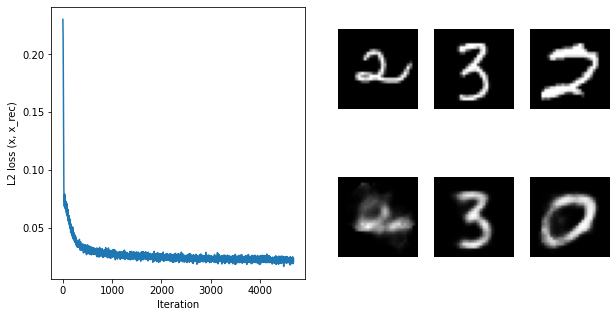

In [6]:
# обучим модель с латентным кодом длины 8
model = AutoEncoder(8)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_model(model, train_dataloader, optimizer)

Для довольно хорошего сжатия картинок из MNIST'a хватает всего 8 латентных переменных!

## 3. Структура и интерпретация латентного пространства.

Главная ценность автоэнкодера как модели - его латентный код. Он крайне насыщенный, т.к. он должен сохранять как можно больше важной информации об объекте. Кроме того, само латентное пространство (множество латентных кодов всех объектов) - довольно плотное и отлично сохраняет структуру исходного пространства - например, похожие объекты в исходном пространстве будут находиться недалеко друг от друга в латентном пространстве. 

В этой части мы проиллюстрируем эти свойства.

### 3.1 Интерполяция латентных кодов

Интерполяция латентного кода - это визуализация процесса движения от одной точки латентного пространства к другой. Обычно интерполируют по прямой - соединяют две точки, соответсвующие реальным объектам, отрезком и смотрят латентные коды через равные части этого отрезка. Для каждой промежуточной точки строят выход декодера. 

Давайте возьмем два случайных объекта из выборки и построим интерполяцию между ними.

In [7]:
for x, _ in train_dataloader:
    break
    
x1 = x[0].to(device)
x2 = x[1].to(device)

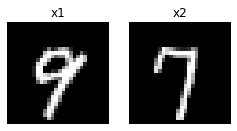

In [8]:
plt.figure(figsize=(4, 2))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('x1')
plt.imshow(x1[0].cpu().detach().numpy(), cmap='gray')

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('x2')
plt.imshow(x2[0].cpu().detach().numpy(), cmap='gray')

In [9]:
# получите латентные коды объектов
z_1 = model.encode(x1[None, :, :, :])
z_2 = model.encode(x2[None, :, :, :])
assert z_1.shape == z_2.shape == torch.Size([1, 8])

# постройте батч с интерполяцией этих латентных кодов по прямой в 11 точках (используйте функцию torch.linspace)
linspace = torch.linspace(0, 1, 11)[:, None].to(device)
z_linspace = z_2 * linspace + z_1 * (1 - linspace)
assert z_linspace.shape == torch.Size([11, 8])

# восстановите для всех латентных кодов изображения
x_linspace = model.decode(z_linspace)
assert x_linspace.shape == torch.Size([11, 1, 28, 28])

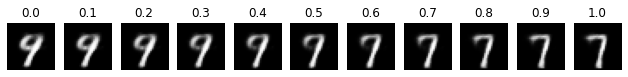

In [10]:
#нарисуем проинтерполированные объекты
plt.figure(figsize=(11, 1))

for i, d in enumerate(np.linspace(0, 1, 11)):
    plt.subplot(1, 11, i + 1)
    plt.axis('off')
    plt.title(f'{d:.2}')
    plt.imshow(x_linspace[i, 0].cpu().detach().numpy(), cmap='gray')


На интерполяция видно, как один объект плавно превращается в другой. Стоит заметить, что почти все промежуточные объекты тоже выглядят довольно правдопободно. Иногда такие интерполяции используют для того, чтобы расширить какой-то маленький датасет.

### 3.2 Структура латентного пространства

Теперь давайте обучим автоэнкодер с **2** латентными кодами, соберем эти латентные коды и нарисуем 2d plot, где латентные коды подсвечены цветами классов исходных объектов.

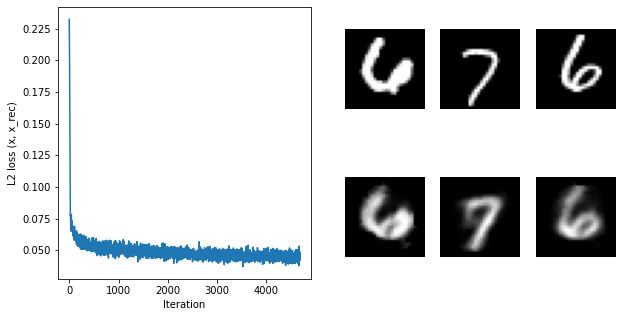

In [11]:
# обучим автоэнкодер с 2 латентными кодами

model_2d = AutoEncoder(2)
model_2d.to(device)

optimizer = optim.Adam(model_2d.parameters(), lr=1e-3)

train_model(model_2d, train_dataloader, optimizer)

In [12]:
def get_latent_codes_and_labels(dataloader, model, num_objects):
    lat_codes = torch.empty((0, model.lat_size)).to(device)
    labels = torch.empty((0)).to(device)

    for batch in dataloader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        cur_lat_codes = model.encode(x)
    
        lat_codes = torch.cat((lat_codes, cur_lat_codes), dim=0)
        labels = torch.cat((labels, y), dim=0)
    
        if lat_codes.shape[0] >= num_objects:
            break
    lat_codes = lat_codes[:num_objects].detach().cpu().numpy()
    labels = labels[:num_objects].detach().cpu().numpy()

    return lat_codes, labels
    
# соберем для 1000 случайных объектов их латентные коды и классы
lat_codes, labels = get_latent_codes_and_labels(train_dataloader, model_2d, 1000)

assert lat_codes.shape == (1000, 2)
assert labels.shape == (1000, )

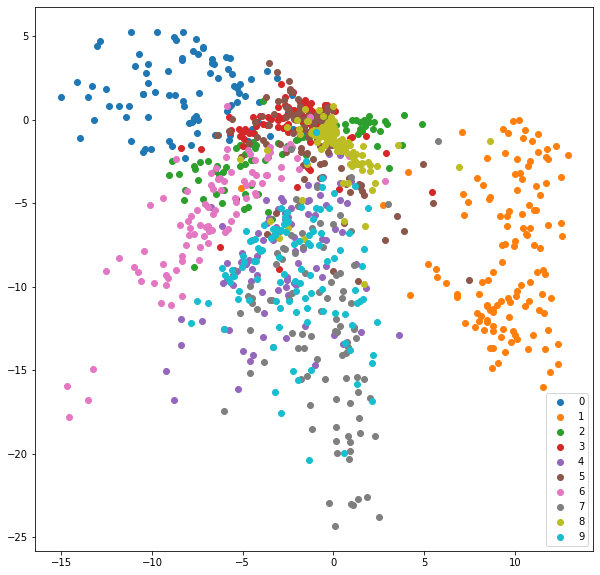

In [13]:
plt.figure(figsize=(10, 10))

for cl in range(10):
    lat_codes_class = lat_codes[labels == cl]
    plt.scatter(lat_codes_class[:, 0], lat_codes_class[:, 1], label=f'{cl}')
plt.legend()
plt.show()

Объекты одного и то же класса находятся в латентном пространстве близко друг к другу! При этом визуально похожие классы (1-4 или 4-9) тоже находятся близко друг к другу.

### 3.3 Структура латентного пространства (продолжение)

А теперь давайте обучим автоэнкодер с **32** латентными кодами, а потом сожмем до размемрности **2** с помощью **t-sne**.

In [6]:
from sklearn.manifold import TSNE

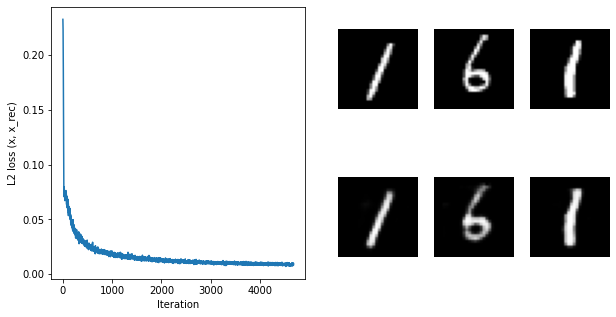

In [15]:
model_big = AutoEncoder(32)
model_big.to(device)
optimizer = optim.Adam(model_big.parameters(), lr=1e-3)

train_model(model_big, train_dataloader, optimizer)

In [16]:
tsne = TSNE(n_components=2)

In [17]:
lat_codes, labels = get_latent_codes_and_labels(train_dataloader, model_big, 1000)

In [18]:
new_codes = tsne.fit_transform(lat_codes)

In [19]:
assert new_codes.shape == (1000, 2)
assert labels.shape == (1000,)

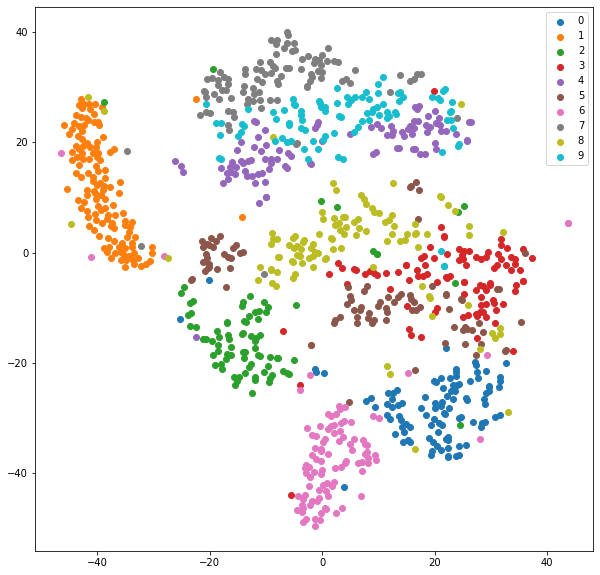

In [20]:
plt.figure(figsize=(10, 10))

for cl in range(10):
    lat_codes_class = new_codes[labels == cl]
    plt.scatter(lat_codes_class[:, 0], lat_codes_class[:, 1], label=f'{cl}')
    
plt.legend()
plt.show()

## 4. Применения

### 4.1 Semi-supervised learning

Представим, что у нас следующая ситуация. Есть огромный датасет (тысячи объектов), но по тем или иным причинам размечена у него только малая часть (скажем, сотня объектов) объектов. Например, причиной может быть дороговизна разметки или необходимость привлечения эксперта. Однако, мы хотим научиться решать эту задачу и должны как-то научиться использовать неразмеченные данные.

В такой ситуации можно обучить автоэнкодер на всем датасете (размеченные + неразмеченные объекты) и использовать его латентные коды для обучения другой модели (например, из классического ML), которая менее требовательна к объему данных.

In [21]:
# предположим, у нас размечено только 1000 (из 50000) объектов из MNIST
# возьмем для них латентные коды

train_lat_codes, train_labels = get_latent_codes_and_labels(train_dataloader, model, 1000)

assert train_lat_codes.shape == (1000, 8)
assert train_labels.shape == (1000, )

# так же обсчитаем весь тест сет
test_lat_codes, test_labels = get_latent_codes_and_labels(test_dataloader, model, 10000)

assert test_lat_codes.shape == (10000, 8)
assert test_labels.shape == (10000, )

In [22]:
# обучим на них случайный лес
from sklearn.ensemble import RandomForestClassifier

clfr = RandomForestClassifier(n_estimators=1000)
clfr.fit(train_lat_codes, train_labels)

RandomForestClassifier(n_estimators=1000)

In [23]:
test_pred = clfr.predict(test_lat_codes)

In [24]:
print(f'Test accuracy: {(test_pred == test_labels).mean()}')

Test accuracy: 0.862


Своего рода это частный случай fine-tuning, но для ситуации, когда исходная сетка (энкодер) обучалась на неразмеченных данных.

### 4.2 Denoising

Кроме того, автоэнкодеры часто используют для очистки исходных данных от шума. Латентный код сохраняет только главную информацию об объекте, отбрасывая шумовые компоненты. 

Давайте реализуем функцию, которая обращает 10% пикселей исходного изображения и обучим на такой выборке автоэнкодер.

In [20]:
class FlipRandomBits(object):
    def __init__(self, flip_ratio=0.1):
        self.flip_ratio = flip_ratio
        
    def __call__(self, x):
        mask = (torch.rand_like(x) < self.flip_ratio)
        x[mask] = 1 - x[mask]
        
        return x

transform = transforms.Compose([transforms.ToTensor(), 
                                FlipRandomBits()])

trainset_with_noise = torchvision.datasets.MNIST(root='./mnist', train=True,
                                        download=True, transform=transform)
train_dataloader_with_noise = torch.utils.data.DataLoader(trainset_with_noise, batch_size=64,
                                          shuffle=True, num_workers=0)


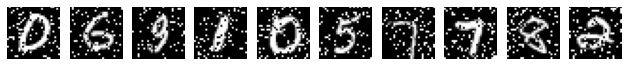

In [21]:
for x, y in train_dataloader_with_noise:
    break

plt.figure(figsize=(11, 1))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(x[i, 0].cpu().detach().numpy(), cmap='gray')

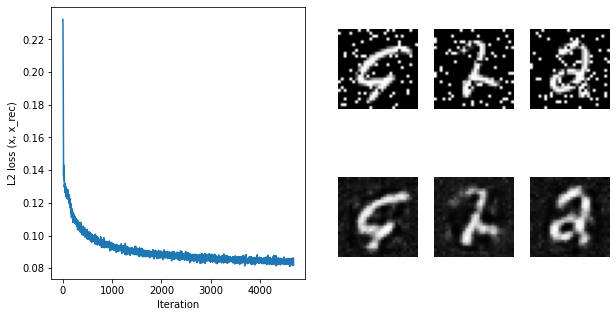

In [29]:
# обучим автоэнкодер на зашумленных данных

model_for_noise = AutoEncoder(64)
model_for_noise.to(device)
optimizer = optim.Adam(model_for_noise.parameters(), lr=1e-3)

train_model(model_for_noise, train_dataloader_with_noise, optimizer)

In [32]:
_, rec_x = model.compute_loss(x.to(device), return_rec=True)

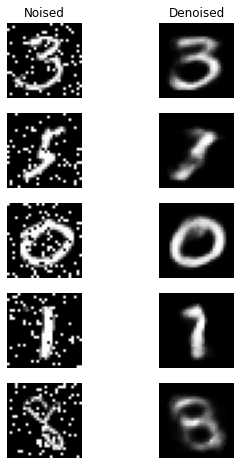

In [44]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(5, 8),)
i = 0

for ax, noised, denoised in zip(axs, x[:10], rec_x[:10]):
    ax[0].imshow(noised[0].cpu().detach().numpy(), cmap='gray')
    ax[1].imshow(denoised[0].cpu().detach().numpy(), cmap='gray')
    ax[0].axis('off')
    ax[1].axis('off')
    if i == 0:
        ax[0].set_title(f'Noised')
        ax[1].set_title(f'Denoised')
        i += 1

## 5. Variational AE

In [378]:
class MNISTEncoder_vae(nn.Module):
    def __init__(self, lat_size):
        super(MNISTEncoder_vae, self).__init__()
        self.lat_size = lat_size

        self.enc_net = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(784, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU())
        
        self.mu = nn.Linear(64, self.lat_size)
        self.log_sigma = nn.Linear(64, self.lat_size)
        
    def forward(self, x):
        
        z = self.enc_net(x)
        mu = self.mu(z)
        log_sigma = self.log_sigma(z)
        
        return mu, log_sigma 
    
class MNISTDecoder_vae(nn.Module):
    def __init__(self, lat_size):
        super(MNISTDecoder_vae, self).__init__()
        self.lat_size = lat_size
        
        self.dec_net = self.dec_net = nn.Sequential(
            nn.Linear(self.lat_size, 128), nn.ReLU(),
            nn.Linear(128, 784), nn.Sigmoid())
        
    def forward(self, z):

        x_rec = self.dec_net(z)
        x_rec = x_rec.view(-1, 1, 28, 28)
        
        return x_rec

In [379]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, lat_size, KL_weight=0.001,
                 encoder_class=MNISTEncoder_vae, 
                 decoder_class=MNISTDecoder_vae,
                 criterion_class=nn.MSELoss,):
        super(VariationalAutoEncoder, self).__init__()
        
        self.lat_size = lat_size
        self.enc = encoder_class(lat_size)
        self.dec = decoder_class(lat_size)
        
        self.criterion = criterion_class()
        
        self.k = 0
        self.KL_weight = KL_weight
        
    def encode(self, x):
        return self.enc(x)
    
    def decode(self, z):
        return self.dec(z)
    
    def sample_z(self, mu, log_sigma):
        eps = torch.randn(mu.shape).to(device)
        return mu + torch.exp(log_sigma / 2) * eps
    
    def custom_loss(self, x, rec_x, mu, log_sigma):
        
        KL = torch.mean(-0.5 * torch.sum(1 + log_sigma - mu ** 2 - log_sigma.exp(), dim = 1), dim = 0)
        recon_loss = self.criterion(x, rec_x)
        
        return KL*self.KL_weight + recon_loss
    
    def compute_loss(self, x, return_rec=False):
        
        mu, log_sigma = self.encode(x)
        z = self.sample_z(mu, log_sigma)
        rec_x = self.decode(z)
        
        loss = self.custom_loss(x, rec_x, mu, log_sigma)
        
        if return_rec:
            return loss, rec_x
        else:
            return loss

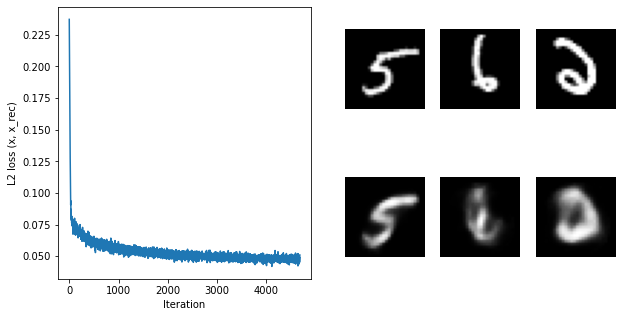

In [380]:
hidden_dim = 32
model_vae = VariationalAutoEncoder(hidden_dim, 0.002)
model_vae.to(device)
optimizer = optim.Adam(model_vae.parameters(), lr=1e-3)

train_model(model_vae, train_dataloader, optimizer, 5)

### 5.1 Interpolation of latent codes

In [368]:
for x, _ in train_dataloader:
    break
    
x1 = x[0].to(device)
x2 = x[1].to(device)

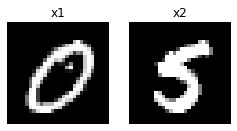

In [369]:
plt.figure(figsize=(4, 2))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('x1')
plt.imshow(x1[0].cpu().detach().numpy(), cmap='gray')

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('x2')
plt.imshow(x2[0].cpu().detach().numpy(), cmap='gray')

In [370]:
# получите латентные коды объектов
z_1_mu, z_1_logs = model_vae.encode(x1[None, :, :, :])
z_2_mu, z_2_logs = model_vae.encode(x2[None, :, :, :])
z_1 = model_vae.sample_z(z_1_mu, z_1_logs)
z_2 = model_vae.sample_z(z_2_mu, z_2_logs)

assert z_1.shape == z_2.shape == torch.Size([1, hidden_dim])

# постройте батч с интерполяцией этих латентных кодов по прямой в 11 точках (используйте функцию torch.linspace)
linspace = torch.linspace(0, 1, 11)[:, None].to(device)
z_linspace = z_2 * linspace + z_1 * (1 - linspace)
# assert z_linspace.shape == torch.Size([11, 8])

# восстановите для всех латентных кодов изображения
x_linspace = model_vae.decode(z_linspace)
assert x_linspace.shape == torch.Size([11, 1, 28, 28])

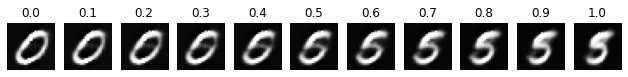

In [371]:
#нарисуем проинтерполированные объекты
plt.figure(figsize=(11, 1))

for i, d in enumerate(np.linspace(0, 1, 11)):
    plt.subplot(1, 11, i + 1)
    plt.axis('off')
    plt.title(f'{d:.2}')
    plt.imshow(x_linspace[i, 0].cpu().detach().numpy(), cmap='gray')


### 5.2 Sampling from the distribution

In [372]:
z = torch.rand((10, hidden_dim), device=device)

In [373]:
sampled_from_z = model_vae.decode(z)

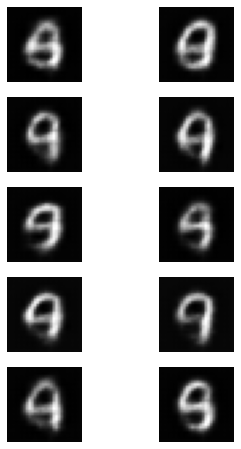

In [374]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(5, 8),)

for ax, sampled in zip(axs.flat, sampled_from_z):
    ax.imshow(sampled[0].cpu().detach().numpy(), cmap='gray')
    ax.axis('off')

### 5.3 Conditional VAE

In [394]:
def train_model_conditional(model, tr_dataloader, optimizer, num_epochs=5, verbose_num_iters=32):
    model.train()
    loss_trace = []
    
    for epoch_i in range(num_epochs):        
        print(f'Epoch {epoch_i + 1}')
        for iter_i, batch in enumerate(tr_dataloader):
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            
            optimizer.zero_grad() # Зануляем градиенты
            
            loss, rec_x = model.compute_loss(x, y, return_rec=True)
            
            loss.backward() # Считаем градиенты
            optimizer.step() # Обновляем параметры модели
            
            loss_trace.append(loss.item())
        
            if (iter_i + 1) % verbose_num_iters == 0:
                clear_output(wait=True)
                plt.figure(figsize=(10, 5))
                
                plt.subplot(1, 2, 1)
                plt.xlabel('Iteration')
                plt.ylabel('L2 loss (x, x_rec)')
                plt.plot(loss_trace)
                
                for i in range(3):
                    plt.subplot(2, 6, 4 + i)
                    plt.axis('off')
                    plt.imshow(x[i, 0].cpu().detach().numpy(), cmap='gray')
                    
                    plt.subplot(2, 6, 10 + i)
                    plt.axis('off')
                    plt.imshow(rec_x[i, 0].cpu().detach().numpy(), cmap='gray')
                    
                plt.show()
                
    model.eval()

In [440]:
class MNISTEncoder_cvae(nn.Module):
    def __init__(self, lat_size):
        super(MNISTEncoder_cvae, self).__init__()
        self.lat_size = lat_size
        
        self.flatten = nn.Flatten()
        self.enc_net = nn.Sequential( 
            nn.Linear(794, 512), nn.ReLU(),
            #nn.Linear(256, 64), nn.ReLU()
        )
        
        self.mu = nn.Linear(512, self.lat_size)
        self.log_sigma = nn.Linear(512, self.lat_size)
        
    def forward(self, x, y):
        
        z = self.flatten(x)
        onehot_y = nn.functional.one_hot(y, 10)
        z = torch.cat([z, onehot_y], dim=1)
        z = self.enc_net(z)
        mu = self.mu(z)
        log_sigma = self.log_sigma(z)
        
        return mu, log_sigma 
    
class MNISTDecoder_cvae(nn.Module):
    def __init__(self, lat_size):
        super(MNISTDecoder_cvae, self).__init__()
        self.lat_size = lat_size
        
        self.dec_net = self.dec_net = nn.Sequential(
            nn.Linear(self.lat_size+10, 512), nn.ReLU(),
            nn.Linear(512, 784), nn.Sigmoid())
        
    def forward(self, z, y):
        
        onehot_y = nn.functional.one_hot(y, 10)
        z_cond = torch.cat([z, onehot_y], dim=1)

        x_rec = self.dec_net(z_cond)
        x_rec = x_rec.view(-1, 1, 28, 28)
        
        return x_rec

In [441]:
class ConditionalVariationalAutoEncoder(nn.Module):
    def __init__(self, lat_size, KL_weight=0.001,
                 encoder_class=MNISTEncoder_cvae, 
                 decoder_class=MNISTDecoder_cvae,
                 criterion_class=nn.MSELoss,):
        super(ConditionalVariationalAutoEncoder, self).__init__()
        
        self.lat_size = lat_size
        self.enc = encoder_class(lat_size)
        self.dec = decoder_class(lat_size)
        
        self.criterion = criterion_class()
        
        self.k = 0
        self.KL_weight = KL_weight
        
    def encode(self, x, y):
        return self.enc(x, y)
    
    def decode(self, z, y):
        return self.dec(z, y)
    
    def sample_z(self, mu, log_sigma):
        eps = torch.randn(mu.shape).to(device)
        return mu + torch.exp(log_sigma / 2) * eps
    
    def custom_loss(self, x, rec_x, mu, log_sigma):
        
        KL = torch.mean(-0.5 * torch.sum(1 + log_sigma - mu ** 2 - log_sigma.exp(), dim = 1), dim = 0)
        recon_loss = self.criterion(x, rec_x)
        
        return KL*self.KL_weight + recon_loss
    
    def compute_loss(self, x, y, return_rec=False):
        
        mu, log_sigma = self.encode(x, y)
        z = self.sample_z(mu, log_sigma)
        rec_x = self.decode(z, y)
        
        loss = self.custom_loss(x, rec_x, mu, log_sigma)
        
        if return_rec:
            return loss, rec_x
        else:
            return loss

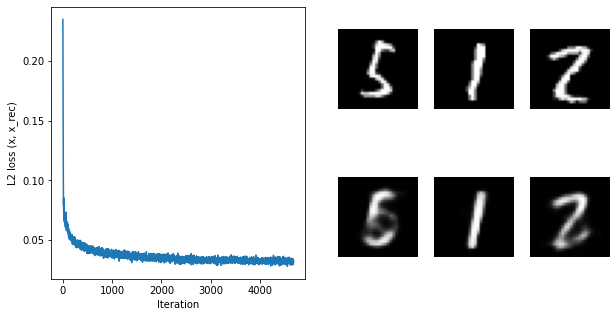

In [442]:
hidden_dim = 32
model_cvae = ConditionalVariationalAutoEncoder(hidden_dim, 0.001)
model_cvae.to(device)
optimizer = optim.Adam(model_cvae.parameters(), lr=1e-3)

train_model_conditional(model_cvae, train_dataloader, optimizer, 5)

In [444]:
z = torch.rand((10, hidden_dim), device=device)
y = torch.randint(0, 10, (10,), device=device)

sampled_from_z = model_cvae.decode(z, y)

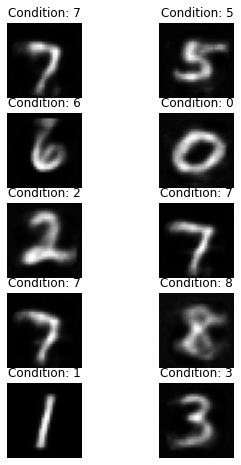

In [450]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(5, 8),)

for ax, sampled, label in zip(axs.flat, sampled_from_z, y):
    ax.imshow(sampled[0].cpu().detach().numpy(), cmap='gray')
    ax.set_title(f'Condition: {label}')
    ax.axis('off')

Статьи с помощью которых я реализовывал последние 2 секции, довольно подробно поясняющие, что происходит:

* [**VAE**](https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/)
* [**Conditional VAE**](https://wiseodd.github.io/techblog/2016/12/17/conditional-vae/)